### 0. 설치 및 설정

In [1]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 12.1 MB/s 
     |████████████████████████████████| 6.6 MB 48.5 MB/s 
     |████████████████████████████████| 895 kB 58.4 MB/s 
     |████████████████████████████████| 77 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 64.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import os
import sys
import pandas as pd
import numpy as np 

import re
import requests

import torch
import torch.nn as nn
import tensorflow as tf

from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm

In [3]:
# GPU 메모리 에러 체크
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
# seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# device type
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"# available GPUs : {torch.cuda.device_count()}")
    print(f"GPU name : {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
print(device)

cpu


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
train_df = pd.read_json('/content/drive/MyDrive/data/klue-sts-v1.1/klue-sts-v1.1_train.json')
dev_df = pd.read_json('/content/drive/MyDrive/data/klue-sts-v1.1/klue-sts-v1.1_dev.json')

### 1. 전처리

In [7]:
train_df.head()

,guid,source,sentence1,sentence2,labels,annotations
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,"{'label': 3.7, 'real-label': 3.714285714285714...","{'agreement': '0:0:0:2:5:0', 'annotators': ['0..."
1,klue-sts-v1_train_00001,policy-sampled,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,"{'label': 0.0, 'real-label': 0.0, 'binary-labe...","{'agreement': '5:0:0:0:0:0', 'annotators': ['1..."
2,klue-sts-v1_train_00002,paraKQC-sampled,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,"{'label': 0.30000000000000004, 'real-label': 0...","{'agreement': '4:2:0:0:0:0', 'annotators': ['1..."
3,klue-sts-v1_train_00003,policy-sampled,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...","고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.","{'label': 0.6000000000000001, 'real-label': 0....","{'agreement': '4:2:1:0:0:0', 'annotators': ['1..."
4,klue-sts-v1_train_00004,airbnb-rtt,"호스트의 답장이 늦으나, 개선될 것으로 보입니다.",호스트 응답이 늦었지만 개선될 것으로 보입니다.,"{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['1..."


In [ ]:
with pd.option_context('display.max_colwidth', None):
  display(train_df.head(1))
# 3.0 보다 평균 점수가 높으면 1 낮으면 0

,guid,source,sentence1,sentence2,labels,annotations
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,"{'label': 3.7, 'real-label': 3.714285714285714, 'binary-label': 1}","{'agreement': '0:0:0:2:5:0', 'annotators': ['07', '13', '15', '10', '12', '02', '19'], 'annotations': [3, 4, 4, 4, 3, 4, 4]}"


In [ ]:
# 데이터셋 shape 확인
# 약 22배 차이
train_df.shape, dev_df.shape

((11668, 6), (519, 6))

In [8]:
train_df['labels_str'] = train_df['labels'].astype(str)

In [9]:
# 중복행 발견
train_df.duplicated(['sentence1', 'sentence2', 'labels_str']).sum()

5

In [10]:
# sentence1, sentence2 동일한 데이터 발견 
# 하나씩만 남기고 제거
train_df[train_df.duplicated(['sentence1','sentence2', 'labels_str'], keep=False)]

,guid,source,sentence1,sentence2,labels,annotations,labels_str
1514,klue-sts-v1_train_01514,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0...","{'label': 4.7, 'real-label': 4.714285714285714..."
1661,klue-sts-v1_train_01661,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1...","{'label': 4.7, 'real-label': 4.666666666666667..."
1715,klue-sts-v1_train_01715,airbnb-rtt,택시타고 공항갔을 때 20유로로 15분내에 도착했었어요.,"택시를 타고 공항에 갔을 때, 15분만에 20유로에 도착했습니다.","{'label': 4.7, 'real-label': 4.666666666666667...","{'agreement': '0:0:0:0:2:4', 'annotators': ['1...","{'label': 4.7, 'real-label': 4.666666666666667..."
3872,klue-sts-v1_train_03872,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1...","{'label': 4.9, 'real-label': 4.857142857142857..."
5139,klue-sts-v1_train_05139,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0...","{'label': 4.6, 'real-label': 4.571428571428571..."
5292,klue-sts-v1_train_05292,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['0...","{'label': 4.7, 'real-label': 4.714285714285714..."
7045,klue-sts-v1_train_07045,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1...","{'label': 4.0, 'real-label': 4.0, 'binary-labe..."
10908,klue-sts-v1_train_10908,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.0, 'real-label': 4.0, 'binary-labe...","{'agreement': '0:0:0:1:5:1', 'annotators': ['1...","{'label': 4.0, 'real-label': 4.0, 'binary-labe..."
10939,klue-sts-v1_train_10939,policy-rtt,지난달 하루 평균 수출액이 전년대비 5.6% 증가한 가운데 자동차는 2017년 11...,"지난 달 평균 일일 수출액이 전년 동월대비 5.6% 증가하면서, 자동차의 수출은 2...","{'label': 4.6, 'real-label': 4.571428571428571...","{'agreement': '0:0:0:0:3:4', 'annotators': ['0...","{'label': 4.6, 'real-label': 4.571428571428571..."
11112,klue-sts-v1_train_11112,policy-rtt,"제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사는 ...","제2차 전략회의에서 대전, 경기, 강원, 전남, 제주, 경남 등 6개 시·도지사가 ...","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1...","{'label': 4.9, 'real-label': 4.857142857142857..."


In [11]:
train_df = train_df.drop_duplicates(['sentence1','sentence2','labels_str'], keep='first', ignore_index=True)

In [12]:
# 확인
train_df.duplicated(['sentence1', 'sentence2','labels_str']).sum()

0

In [13]:
# 확인
dev_df.duplicated(['sentence1','sentence2']).sum()

0

In [14]:
#f1 score로 메트릭 정할 경우 binary
#pearson으로 할경우 [0,5]

train_df['binary'] = [train_df['labels'][i]['binary-label'] for i in range(len(train_df))]
train_df['label'] = [train_df['labels'][i]['real-label'] for i in range(len(train_df))]

In [15]:
train_df.head()

,guid,source,sentence1,sentence2,labels,annotations,labels_str,binary,label
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,"{'label': 3.7, 'real-label': 3.714285714285714...","{'agreement': '0:0:0:2:5:0', 'annotators': ['0...","{'label': 3.7, 'real-label': 3.714285714285714...",1,3.714286
1,klue-sts-v1_train_00001,policy-sampled,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,"{'label': 0.0, 'real-label': 0.0, 'binary-labe...","{'agreement': '5:0:0:0:0:0', 'annotators': ['1...","{'label': 0.0, 'real-label': 0.0, 'binary-labe...",0,0.000000
2,klue-sts-v1_train_00002,paraKQC-sampled,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,"{'label': 0.30000000000000004, 'real-label': 0...","{'agreement': '4:2:0:0:0:0', 'annotators': ['1...","{'label': 0.30000000000000004, 'real-label': 0...",0,0.333333
3,klue-sts-v1_train_00003,policy-sampled,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...","고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.","{'label': 0.6000000000000001, 'real-label': 0....","{'agreement': '4:2:1:0:0:0', 'annotators': ['1...","{'label': 0.6000000000000001, 'real-label': 0....",0,0.571429
4,klue-sts-v1_train_00004,airbnb-rtt,"호스트의 답장이 늦으나, 개선될 것으로 보입니다.",호스트 응답이 늦었지만 개선될 것으로 보입니다.,"{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['1...","{'label': 4.7, 'real-label': 4.714285714285714...",1,4.714286


### 시각화

In [ ]:
import seaborn as sns

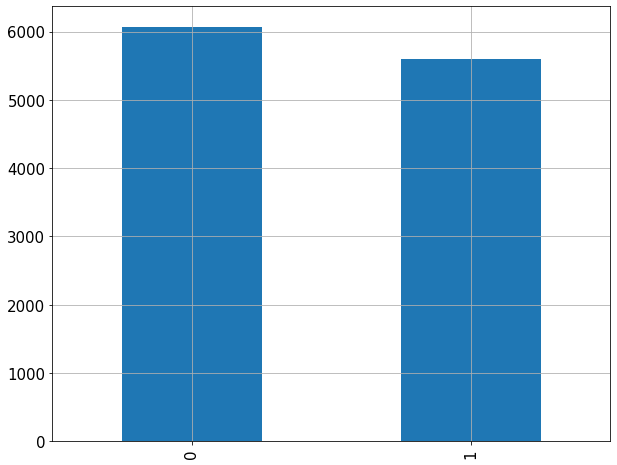

In [ ]:
CountStatus = pd.value_counts(train_df['binary'].values, sort=True)
CountStatus.plot.bar()
CountStatus.plot.bar(grid=True, figsize=(10,8), fontsize=15);

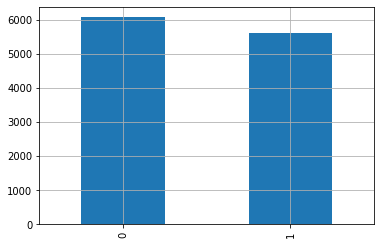

In [ ]:
train_df['binary'].value_counts().plot.bar(grid=True);

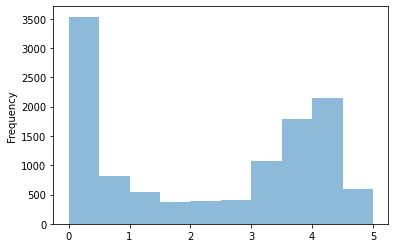

In [ ]:
train_df['label'].plot.hist(alpha=0.5);

### 1-1. 띄어쓰기, 맞춤법 오류?
에어비앤비 리뷰는 맞춤법 오류가 많을 수 있음. 

In [ ]:
#pyKoSpace로 띄어쓰기
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-0spv2lz4
  Running command git clone -q https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-0spv2lz4
     |███████▉                        | 112.6 MB 19.0 MB/s eta 0:00:19
ERROR: Operation cancelled by user


In [ ]:
from pykospacing import Spacing
spacing = Spacing()

ModuleNotFoundError: ignored

In [ ]:
#train_df['sentence1'].apply(spacing)

In [ ]:
# 돌려봤는데, 얼추 봐선 띄어쓰기가 오히려 의미를 해칠 수도 있다고 판단되어 일단 저장만 해놓는걸로
train_df['sentence1']

In [ ]:
# 맞춤법 오류
!pip install git+https://github.com/ssut/py-hanspell.git


In [ ]:
from hanspell import spell_checker
result = spell_checker.check(u'안녕 하세요. 저는 한국인 입니다. 이문장은 한글로 작성됬습니다.')
result.as_dict()['checked']

In [ ]:
# 30분 걸림. 안하는게 나음
#sentence1
checked_lst = []
for i in range(len(train_df)):
  checked = spell_checker.check(train_df['sentence1'][i]).as_dict()['checked']
  checked_lst.append(checked)

In [ ]:
# 특수문자 때문에 에러가 발생해서 일단 특문 클렌징 진행
temp = spell_checker.check(train_df['sentence2'][1308]).as_dict()

In [ ]:
def special_cleansing(text):
    text = re.sub('[-=+#/\:^$@*\"※~&%ㆍ』\\‘〈〉|\(\)\[\]\<\>`\'…》《]','', text)
    return text

In [ ]:
train_df['sentence2'] = train_df['sentence2'].apply(special_cleansing)

In [ ]:
train_df['sentence2'][1308]

In [ ]:
#sentence2
checked_lst2 = []
temp_lst = []
for i in range(len(train_df)):
  temp = spell_checker.check(train_df['sentence2'][i]).as_dict()
  checked = temp['checked']
  err = temp['errors']
  checked_lst2.append(checked)
  temp_lst.append(err)

In [ ]:
import numpy as np
np.mean(temp_lst)
#평균 0.56개의 맞춤법 에러 > 1개도 안고침;

In [ ]:
train_df['spell_checked1'] = checked_lst
train_df['spell_checked2'] = checked_lst2
train_df.head()

### 1-2 숫자,영어,특문 제거

 별도로 불용어를 제거하지말고 토큰화 단계에서 조사, 접속사를 제거하자.




In [16]:
# 영어, 일본어, 한자, 특수문자 제거 (숫자 남겨두기)
def cleansing(text):
    text = re.sub('a-zA-Z一-龥㐀-䶵豈-龎[-=+,#/\?:^$.@*\"※~&%ㆍ·!』\\‘〈〉|\(\)\[\]\<\>`\'…》《]','', text)
    return text

In [17]:
train_df['cleansed'] = train_df['sentence1'].apply(cleansing)
train_df['cleansed2'] = train_df['sentence2'].apply(cleansing)

In [18]:
train_df.head()

,guid,source,sentence1,sentence2,labels,annotations,labels_str,binary,label,cleansed,cleansed2
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,"{'label': 3.7, 'real-label': 3.714285714285714...","{'agreement': '0:0:0:2:5:0', 'annotators': ['0...","{'label': 3.7, 'real-label': 3.714285714285714...",1,3.714286,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.
1,klue-sts-v1_train_00001,policy-sampled,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,"{'label': 0.0, 'real-label': 0.0, 'binary-labe...","{'agreement': '5:0:0:0:0:0', 'annotators': ['1...","{'label': 0.0, 'real-label': 0.0, 'binary-labe...",0,0.000000,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.
2,klue-sts-v1_train_00002,paraKQC-sampled,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,"{'label': 0.30000000000000004, 'real-label': 0...","{'agreement': '4:2:0:0:0:0', 'annotators': ['1...","{'label': 0.30000000000000004, 'real-label': 0...",0,0.333333,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘
3,klue-sts-v1_train_00003,policy-sampled,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...","고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.","{'label': 0.6000000000000001, 'real-label': 0....","{'agreement': '4:2:1:0:0:0', 'annotators': ['1...","{'label': 0.6000000000000001, 'real-label': 0....",0,0.571429,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...","고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다."
4,klue-sts-v1_train_00004,airbnb-rtt,"호스트의 답장이 늦으나, 개선될 것으로 보입니다.",호스트 응답이 늦었지만 개선될 것으로 보입니다.,"{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['1...","{'label': 4.7, 'real-label': 4.714285714285714...",1,4.714286,"호스트의 답장이 늦으나, 개선될 것으로 보입니다.",호스트 응답이 늦었지만 개선될 것으로 보입니다.


In [19]:
dev_df['cleansed'] = dev_df['sentence1'].apply(cleansing)
dev_df['cleansed2'] = dev_df['sentence2'].apply(cleansing)

In [70]:
train_df.sample()

,guid,source,sentence1,sentence2,labels,annotations,labels_str,binary,label,cleansed,cleansed2
234,klue-sts-v1_train_00234,paraKQC-para,너가 추천해줄 수 있는 가장 효과적인 거실 청소 방법은 뭐야?,너가 생각하긴 거실을 가장 효과적으로 청소하려면 어떻게 해야될 것 같아?,"{'label': 3.6, 'real-label': 3.571428571428572...","{'agreement': '0:0:0:3:4:0', 'annotators': ['0...","{'label': 3.6, 'real-label': 3.571428571428572...",1,3.571429,너가 추천해줄 수 있는 가장 효과적인 거실 청소 방법은 뭐야?,너가 생각하긴 거실을 가장 효과적으로 청소하려면 어떻게 해야될 것 같아?


#### 1-3 형태소분리(khaiii)


In [20]:
!git clone https://github.com/kakao/khaiii.git 
!pip install cmake 
!mkdir build 
!cd build && cmake /content/khaiii 
!cd /content/build/ && make all 
!cd /content/build/ && make resource 
!cd /content/build && make install 
!cd /content/build && make package_python 
!pip install /content/build/package_python


Cloning into 'khaiii'...
remote: Enumerating objects: 1024, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 1024 (delta 3), reused 0 (delta 0), pack-reused 1016
Receiving objects: 100% (1024/1024), 33.03 MiB | 26.06 MiB/s, done.
^C
CMake Error: The source directory "/content/khaiii" does not exist.
Specify --help for usage, or press the help button on the CMake GUI.
make: *** No rule to make target 'all'.  Stop.
make: *** No rule to make target 'resource'.  Stop.
make: *** No rule to make target 'install'.  Stop.
make: *** No rule to make target 'package_python'.  Stop.
ERROR: Invalid requirement: '/content/build/package_python'
Hint: It looks like a path. File '/content/build/package_python' does not exist.


In [45]:
from konlpy import tag


def tagging(tagger, text):
    r = []
    try:
        r = getattr(tag, tagger)().pos(text)
    except Exception as e:
        print("Uhoh,", e)
    return r

kkma = tag.Kkma()
print(kkma.morphs(u'공부를 하면할수록 모르는게 많다는 것을 알게 됩니다.'))
print(kkma.nouns(u'대학에서 DB, 통계학, 이산수학 등을 배웠지만...'))
print(kkma.pos(u'다 까먹어버렸네요?ㅋㅋ'))
print(kkma.sentences(u'그래도 계속 공부합니다. 재밌으니까!'))

['공부', '를', '하', '면', '하', 'ㄹ수록', '모르', '는', '것', '이', '많', '다는', '것', '을', '알', '게', '되', 'ㅂ니다', '.']
['대학', '통계학', '이산', '이산수학', '수학', '등']
[('다', 'MAG'), ('까먹', 'VV'), ('어', 'ECD'), ('버리', 'VXV'), ('었', 'EPT'), ('네요', 'EFN'), ('?', 'SF'), ('ㅋㅋ', 'EMO')]
['그래도 계속 공부합니다.', '재밌으니까!']


In [ ]:
from khaiii import KhaiiiApi 
api = KhaiiiApi()

In [ ]:
# 조사, 접속사 제거 유무 결정하기
# 출처 - https://sy-log.tistory.com/58 (품사리스트)
# 의존명사, 주격조사, 보격조사, 관형격조사, 목적격조사, 부사격조사, 호격조사, 인용격조사, 보조사, 접속조사 제거
stop_tags = ['NNB', 'JKS','JKC','JKG','JKO','JKB','JKV','JKQ','JX','JC']
# 더 제거해보자. 선어말 어미,연결 어미, 명사형 전성 어미, 관형형 전성 어미, 동사 파생 접미사, 형용사 파생 접미사 제거
more_stop_tags = ['NNB', 'JKS','JKC','JKG','JKO','JKB','JKV','JKQ','JX','JC',
                  'EP','EC','EF','ETN','ETM','XSN','XSV','XSA']

In [ ]:
# 예시
khaii_lst = []
test_sents = train_df['sentence1'][:5]
for sent in test_sents:
  morph_list = []  
  for word in api.analyze(sent):
    for morph in word.morphs:
      if morph.tag not in more_stop_tags: # 이부분 제외하면 조사+접속사 제거하지 않고 출력
        morph_list.append(morph.lex)
  text = ' '.join(morph_list)
  khaii_lst.append(text)
khaii_lst

In [ ]:
khaii_lst = []
test_sents = train_df['cleansed']
for sent in test_sents:
  morph_list = []  
  for word in api.analyze(sent):
    for morph in word.morphs:
      if morph.tag not in more_stop_tags: # 이부분 제외하면 조사+접속사 제거하지 않고 출력
        morph_list.append(morph.lex)
  text = ' '.join(morph_list)
  khaii_lst.append(text)
khaii_lst[:5]

In [ ]:
khaii_lst = []
test_sents = train_df['cleansed']
for sent in test_sents:
  morph_list = []  
  for word in api.analyze(sent):
    for morph in word.morphs:
        morph_list.append(morph.lex + '/' +morph.tag)
  text = ' '.join(morph_list)
  khaii_lst.append(text)
khaii_lst[:5]

In [ ]:
khaii_lst2 = []
test_sents = train_df['cleansed2']
for sent in test_sents:
  morph_list = []  
  for word in api.analyze(sent):
    for morph in word.morphs:
      if morph.tag not in more_stop_tags: # 이부분 제외하면 조사+접속사 제거하지 않고 출력
        morph_list.append(morph.lex)
  text = ' '.join(morph_list)
  khaii_lst2.append(text)
khaii_lst2[-5:]

In [ ]:
train_df['khaii1'] = khaii_lst
train_df['khaii2'] = khaii_lst2
train_df.head()

In [ ]:
# validation도 해주기
khaii_lst = []
test_sents = dev_df['cleansed']
for sent in test_sents:
  morph_list = []  
  for word in api.analyze(sent):
    for morph in word.morphs:
      if morph.tag not in more_stop_tags: # 이부분 제외하면 조사+접속사 제거하지 않고 출력
        morph_list.append(morph.lex)
  text = ' '.join(morph_list)
  khaii_lst.append(text)
khaii_lst[:5]

In [ ]:
khaii_lst2 = []
test_sents = dev_df['cleansed2']
for sent in test_sents:
  morph_list = []  
  for word in api.analyze(sent):
    for morph in word.morphs:
      if morph.tag not in more_stop_tags: # 이부분 제외하면 조사+접속사 제거하지 않고 출력
        morph_list.append(morph.lex)
  text = ' '.join(morph_list)
  khaii_lst2.append(text)
khaii_lst2[:5]

In [ ]:
dev_df['khaii1'] = khaii_lst
dev_df['khaii2'] = khaii_lst2
dev_df.head()

In [ ]:
dev_df['binary'] = [dev_df['labels'][i]['binary-label'] for i in range(len(dev_df))]
dev_df['label'] = [dev_df['labels'][i]['real-label'] for i in range(len(dev_df))]

고민할 지점
1. 형태소 분리 전처리 사용할 것인가? 하지않고 그대로 사전학습 모델 토크나이저 사용할 것인가?
2. 형태소 분리 사용한다면 조사 제거할것인가?


In [ ]:
cd drive/MyDrive/data

In [ ]:
train_df.to_csv('klue_sts_preprocessed.csv', index=False)

In [ ]:
dev_df.to_csv('klue_sts_preprocessed_dev.csv', index=False)

In [ ]:
len(train_df)

#### 4. Pororo


In [ ]:
!pip install pororo

In [ ]:
!pip install torch==1.6

In [ ]:
torch.__version__

In [ ]:
from pororo import Pororo

In [ ]:
!pip install python-mecab-ko

In [ ]:
Pororo.available_models('sts')

In [ ]:
pos = Pororo(task='pos',lang='ko')

In [ ]:
pos("숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.")

#### 센텐스피스


In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm
import csv

In [ ]:
cd '/content/drive/MyDrive/data/klue-sts-v1.1'

In [ ]:
with open('klue_review.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_df['sentence1']))

In [ ]:
spm.SentencePieceTrainer.Train('--input=klue_review.txt \
--model_prefix=klue --vocab_size=5000 --model_type=bpe --max_sentence_length=9999')

In [ ]:
vocab_lst = pd.read_csv('klue.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
vocab_lst[:10]

In [ ]:
vocab_lst.sample(10)

In [ ]:
sp = spm.SentencePieceProcessor()
vocab_file = "klue.model"
sp.load(vocab_file)

In [ ]:
lines = [
  "숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.",
  "호스트 응답이 늦었지만 개선될 것으로 보입니다",
]
for line in lines:
  print(line)
  print(' '.join(sp.encode_as_pieces(line)))
  print(sp.encode_as_ids(line))
  print()

### 5. KEDA

In [ ]:
!git clone https://github.com/catSirup/KorEDA.git

Cloning into 'KorEDA'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 7), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [ ]:
cd KorEDA

/content/KorEDA/KorEDA


In [ ]:
from eda import *

In [ ]:
EDA("숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.", num_aug=6)

['소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 '숙소 위치는 찾기 한국의 일반적인 쉽고 반지하 숙소입니다.',
 '소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.',
 '숙소 찾기 위치는 쉽고 일반적인 한국의 반지하 숙소입니다.',
 '숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.']

In [ ]:
def rm_duplicate(x):
  return list(dict.fromkeys(x))

In [ ]:
lst = EDA("형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요", num_aug=6)
rm_duplicate(lst)

['형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요',
 '형이 다시 캐나다 들어가야 하니 바꾸지 마세요',
 '형이 다시 캐나다 일정은 하니 가족모임 들어가야 바꾸지 마세요',
 '형이 캐나다 다시 들어가야 하니 가족모임 일정은 바꾸지 마세요']

In [ ]:
aug = []
sents = train_df['cleansed']
for x in sents:
  lst = rm_duplicate(EDA(x, num_aug=6))
  aug.append(lst)
aug[-2:]

[['개 1마리 고양이 3마리 너무 귀여워요',
  '개 너무 고양이 3마리 1마리 귀여워요',
  '개 1마리 이 3마리 너무 귀여워요',
  '개 1마리 귀여워요 3마리 너무 고양이'],
 ['회 홍보 메일은 회신 메일을 보내지마',
  '학회 메일을 메일은 회신 홍보 보내지마',
  '학회 홍보 메일은 회신 메일을',
  '학회 홍보 메일은 회신 메일을 보내지마',
  '학회 홍보 메일은 회신 학 메일을 보내지마']]

In [ ]:
len(train_df)

11661

In [ ]:
# 30분 걸림
z = len(train_df)
for i in range(len(aug)):
    for j in range(len(aug[i])):
        train_df = train_df.append(train_df.loc[i], ignore_index=True)
        z += 1
        train_df.loc[z, 'sentence1'] = aug[i][j]

In [ ]:
# 11661 > 62723 증가
len(train_df)

62723

In [ ]:
# duplicated 확인
train_df.duplicated(['sentence1', 'sentence2']).sum()

1334

In [ ]:
# 중복 제거 
train_df = train_df.drop_duplicates(['sentence1','sentence2'], keep='first', ignore_index=True)

In [ ]:
len(train_df)

61389

In [ ]:
train_df.iloc[12000]

guid                                     klue-sts-v1_train_00076
source                                           paraKQC-sampled
sentence1                        토요일 놀러가실건가요 금요일과 언제 중에 골라주시겠습니까
sentence2                       올해에 예정되어 있는 연휴들 리스트 각각 언제인지 알려줘.
labels         {'label': 0.2, 'real-label': 0.166666666666666...
annotations    {'agreement': '5:1:0:0:0:0', 'annotators': ['1...
binary                                                       0.0
label                                                   0.166667
cleansed                         언제 놀러가실건가요 금요일과 토요일 중에 골라주시겠습니까
cleansed2                        올해에 예정되어 있는 연휴들 리스트 각각 언제인지 알려줘
Name: 12000, dtype: object

In [ ]:
df.head()

,guid,source,sentence1,sentence3,labels,annotations,binary,label,cleansed,cleansed2
0,klue-sts-v1_train_00000,airbnb-rtt,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다.,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다.,"{'label': 3.7, 'real-label': 3.714285714285714...","{'agreement': '0:0:0:2:5:0', 'annotators': ['0...",1.0,3.714286,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다
1,klue-sts-v1_train_00001,policy-sampled,위반행위 조사 등을 거부·방해·기피한 자는 500만원 이하 과태료 부과 대상이다.,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다.,"{'label': 0.0, 'real-label': 0.0, 'binary-labe...","{'agreement': '5:0:0:0:0:0', 'annotators': ['1...",0.0,0.000000,위반행위 조사 등을 거부방해기피한 자는 500만원 이하 과태료 부과 대상이다,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다
2,klue-sts-v1_train_00002,paraKQC-sampled,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘.,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,"{'label': 0.30000000000000004, 'real-label': 0...","{'agreement': '4:2:0:0:0:0', 'annotators': ['1...",0.0,0.333333,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘
3,klue-sts-v1_train_00003,policy-sampled,"긴급 고용안정지원금은 지역고용대응 등 특별지원금, 지자체별 소상공인 지원사업, 취업...","고용보험이 1차 고용안전망이라면, 국민취업지원제도는 2차 고용안전망입니다.","{'label': 0.6000000000000001, 'real-label': 0....","{'agreement': '4:2:1:0:0:0', 'annotators': ['1...",0.0,0.571429,긴급 고용안정지원금은 지역고용대응 등 특별지원금 지자체별 소상공인 지원사업 취업성공...,고용보험이 1차 고용안전망이라면 국민취업지원제도는 2차 고용안전망입니다
4,klue-sts-v1_train_00004,airbnb-rtt,"호스트의 답장이 늦으나, 개선될 것으로 보입니다.",호스트 응답이 늦었지만 개선될 것으로 보입니다.,"{'label': 4.7, 'real-label': 4.714285714285714...","{'agreement': '0:0:0:0:2:5', 'annotators': ['1...",1.0,4.714286,호스트의 답장이 늦으나 개선될 것으로 보입니다,호스트 응답이 늦었지만 개선될 것으로 보입니다


In [ ]:
train_df.rename(columns = {'cleansed2' : 'sentence2'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_df.columns

Index(['guid', 'source', 'sentence1', 'delete', 'labels', 'annotations',
       'binary', 'label', 'cleansed', 'sentence2'],
      dtype='object')

In [ ]:
column_names = train_df.columns.values
column_names[3] = 'delete'
train_df.columns = column_names

In [ ]:
cd drive/MyDrive/data

/content/drive/MyDrive/data


In [ ]:
train_df[['guid','sentence1','sentence2','labels','label']].to_csv('klue_sts_train_aug.csv', index=False)

In [ ]:
pwd

'/content/KorEDA/KorEDA'

In [ ]:
dev_df

,guid,source,sentence1,sentence2,labels,annotations,cleansed,cleansed2
0,klue-sts-v1_dev_00000,airbnb-rtt,무엇보다도 호스트분들이 너무 친절하셨습니다.,"무엇보다도, 호스트들은 매우 친절했습니다.","{'label': 4.9, 'real-label': 4.857142857142857...","{'agreement': '0:0:0:0:1:6', 'annotators': ['1...",무엇보다도 호스트분들이 너무 친절하셨습니다,무엇보다도 호스트들은 매우 친절했습니다
1,klue-sts-v1_dev_00001,airbnb-sampled,주요 관광지 모두 걸어서 이동가능합니다.,위치는 피렌체 중심가까지 걸어서 이동 가능합니다.,"{'label': 1.4, 'real-label': 1.428571428571429...","{'agreement': '0:4:3:0:0:0', 'annotators': ['1...",주요 관광지 모두 걸어서 이동가능합니다,위치는 피렌체 중심가까지 걸어서 이동 가능합니다
2,klue-sts-v1_dev_00002,policy-sampled,학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...,"{'label': 1.3, 'real-label': 1.285714285714286...","{'agreement': '0:5:2:0:0:0', 'annotators': ['0...",학생들의 균형 있는 영어능력을 향상시킬 수 있는 학교 수업을 유도하기 위해 2018...,영어 영역의 경우 학생들이 한글 해석본을 암기하는 문제를 해소하기 위해 2016학년...
3,klue-sts-v1_dev_00003,airbnb-rtt,"다만, 도로와 인접해서 거리의 소음이 들려요.","하지만, 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다.","{'label': 3.7, 'real-label': 3.714285714285714...","{'agreement': '0:0:0:2:5:0', 'annotators': ['1...",다만 도로와 인접해서 거리의 소음이 들려요,하지만 길과 가깝기 때문에 거리의 소음을 들을 수 있습니다
4,klue-sts-v1_dev_00004,paraKQC-para,형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요.,가족 모임 일정은 바꾸지 말도록 하십시오.,"{'label': 2.5, 'real-label': 2.5, 'binary-labe...","{'agreement': '1:0:1:3:1:0', 'annotators': ['0...",형이 다시 캐나다 들어가야 하니 가족모임 일정은 바꾸지 마세요,가족 모임 일정은 바꾸지 말도록 하십시오
...,...,...,...,...,...,...,...,...
514,klue-sts-v1_dev_00514,policy-rtt,"문체부는 이를 연차적으로 확대, 시행해 학교운동부와 스포츠클럽 간의 연계를 강화한다.",문화체육관광부는 학교스포츠학과와 스포츠클럽의 연계성을 강화하기 위해 매년 이 프로그...,"{'label': 2.2, 'real-label': 2.2, 'binary-labe...","{'agreement': '0:1:2:2:0:0', 'annotators': ['0...",문체부는 이를 연차적으로 확대 시행해 학교운동부와 스포츠클럽 간의 연계를 강화한다,문화체육관광부는 학교스포츠학과와 스포츠클럽의 연계성을 강화하기 위해 매년 이 프로그...
515,klue-sts-v1_dev_00515,airbnb-sampled,일단 정확한 정보와 빠른 답변이 정말 좋았습니다.,호스트의 빠른 답변과 유용한 정보들이 정말 좋습니다.,"{'label': 2.8, 'real-label': 2.833333333333333...","{'agreement': '0:0:1:5:0:0', 'annotators': ['0...",일단 정확한 정보와 빠른 답변이 정말 좋았습니다,호스트의 빠른 답변과 유용한 정보들이 정말 좋습니다
516,klue-sts-v1_dev_00516,airbnb-sampled,게스트에 대한 배려가 묻어나는 시설들이었습니다.,우선 공간에 대한 센스가 돋보이는 곳이었습니다.,"{'label': 0.30000000000000004, 'real-label': 0...","{'agreement': '4:2:0:0:0:0', 'annotators': ['1...",게스트에 대한 배려가 묻어나는 시설들이었습니다,우선 공간에 대한 센스가 돋보이는 곳이었습니다
517,klue-sts-v1_dev_00517,policy-sampled,밤하늘을 배경으로 ‘비대면 드론쇼’도 펼쳐진다.,‘비대면 실감형 문화공연 플랫폼’ 개념도.,"{'label': 0.30000000000000004, 'real-label': 0...","{'agreement': '5:0:1:0:0:0', 'annotators': ['0...",밤하늘을 배경으로 비대면 드론쇼’도 펼쳐진다,비대면 실감형 문화공연 플랫폼’ 개념도
